# MOVIE ANALYSIS

### Flatiron Phase 2 Project

### June 25, 2023

</br>

---

## Team Members

- Rajesh Reddy (Technical Lead)
- > rredd002@gmail.com

- Sangyun (Yun) Thom (GitHub Lead)
- > sangyun.thom@gmail.com

- Morgan Goode (Presentation Lead)
- > morgan.h.goode@gmail.com

</br>

---

## Project Links

For more information on our project, please view our:


- [Project GitHub Page](https://github.com/SangyunT/Movie_Analysis)

- [Project Tableau Dashboard](https://public.tableau.com/app/profile/morgan.goode/viz/imdb_movie_analysis/MedianProfitByGenre)


## Business Problem

Our company sees all the big companies creating original video content and we want to get a foot in the industry. We have decided to create a new movie studio, but we don’t know anything about creating movies. Our data science team is charged with exploring what types of films are currently doing the best at the box office. Then we must translate those findings into actionable insights that the head of our company's new movie studio can use to help decide what type of films to create.

## Data Overview

We retrieved box office data from two databases: IMDB movie ratings and The Numbers for the production budget and revenue.

We focused on movies released between 2010 and 2018 because there was only 3 months of the production budget data for 2019. This resulted in about 1600 movies to analyze from.

The main categories of data that are relevant for our analysis are:

- The main genre for the movie

- The production budget and the worldwide gross

- Release date by month and year

The additional categories we computed for our analysis are:

- Profit for each movie

- ROI for each movie

There is also data we do not use, such as:

- The movie ratings by the fans

- The directors of the movies

The main limitations in our dataset:

- Movies can be separated into multiple genres, but we are only using 1 main genre for our analysis

- The dataset does not include movies for the last 4 years


## Methods Overview

For data analysis and visualizations, we use aggregate methods to group our data

- We merged data between IMDB and The Numbers using movie titles

- We compare movies by genre and recommend the genres which will result in the highest profits at the box office

  - Within this notebook and our Tableau dashboard, we use bar graphs to show the difference in profits by genre and a line graph to plot profits by month for our 4 main genres


## Preliminary Data Processing

Before data cleaning, imputation, exploratory data analysis, and visualizations of the date we have, we need to:

- Import package dependencies

- Ensure the necessary files are present

- Import the necessary files

In [232]:
# Importing the necessary packages for our analysis
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline

In [233]:
# Connecting to the IMDB SQL database
conn = sqlite3.connect("im.db")

In [234]:
# Loading the Movie Budgets csv
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

## Data Cleaning and Imputation

Before we begin exploratory data analysis and create visualizations, we need to clean the dataset and impute some values

In [235]:
# Creating a function to remove punctuation from a string
import string
exclude = set(string.punctuation)
def remove_punctuation(x):
    """
    Helper function to remove punctuation from a string
    x: any string
    """
    try:
        x = ''.join(ch for ch in x if ch not in exclude)
    except:
        pass
    return x
# Apply the function to the DataFrame

In [236]:
# Removing punctuation from movie column in budgets, then converting to title format to standardize the data
budgets.movie = budgets.movie.apply(remove_punctuation)
budgets['movie'] = budgets['movie'].str.title()

In [237]:
# Create new dataframe using movie title, start year, runtime, genres, and ratings from IMDB database
df = pd.read_sql(
    """
    SELECT  movie_basics.movie_id, original_title, start_year, runtime_minutes, genres, averagerating, numvotes
    FROM movie_basics
    JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
    WHERE runtime_minutes	IS NOT NULL;
    """, conn
)

In [238]:
# Split the genres into 3 separate columns
df[['main_genre', 'subgenre_1', 'subgenre_2']] = df['genres'].str.split(',', expand=True)

In [239]:
# Create a dataframe of director information
df_directors_persons = pd.read_sql(
    """
    SELECT movie_id, directors.person_id, primary_name, birth_year, death_year, primary_profession
    FROM persons
    JOIN directors
    ON persons.person_id = directors.person_id
    GROUP BY movie_id
    ORDER BY primary_name;
    """, conn
)

In [240]:
# Merge the 2 dataframes on movie title
directors = pd.merge(df, df_directors_persons, on='movie_id', how='left')

In [241]:
# Include only movies between 2009
directors = directors[(directors['start_year'] > 2009)]

In [242]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66236 entries, 0 to 66235
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            66236 non-null  object 
 1   original_title      66236 non-null  object 
 2   start_year          66236 non-null  int64  
 3   runtime_minutes     66236 non-null  float64
 4   genres              65720 non-null  object 
 5   averagerating       66236 non-null  float64
 6   numvotes            66236 non-null  int64  
 7   main_genre          65720 non-null  object 
 8   subgenre_1          34877 non-null  object 
 9   subgenre_2          17840 non-null  object 
 10  person_id           65760 non-null  object 
 11  primary_name        65760 non-null  object 
 12  birth_year          20644 non-null  float64
 13  death_year          536 non-null    float64
 14  primary_profession  65704 non-null  object 
dtypes: float64(4), int64(2), object(9)
memory usage: 8.1+

In [243]:
# Removing punctuation from original title column in directors, then converting to title format to standardize the data
directors.original_title = directors.original_title.apply(remove_punctuation)
directors.original_title = directors.original_title.str.title()

In [244]:
# Creating a new dataframe by merging directors and budgets on movie title
new_csv = directors.merge(budgets, how='inner', left_on='original_title', right_on='movie')

In [245]:
new_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 0 to 2648
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            2649 non-null   object 
 1   original_title      2649 non-null   object 
 2   start_year          2649 non-null   int64  
 3   runtime_minutes     2649 non-null   float64
 4   genres              2646 non-null   object 
 5   averagerating       2649 non-null   float64
 6   numvotes            2649 non-null   int64  
 7   main_genre          2646 non-null   object 
 8   subgenre_1          2063 non-null   object 
 9   subgenre_2          1439 non-null   object 
 10  person_id           2645 non-null   object 
 11  primary_name        2645 non-null   object 
 12  birth_year          1531 non-null   float64
 13  death_year          26 non-null     float64
 14  primary_profession  2645 non-null   object 
 15  id                  2649 non-null   int64  
 16  releas

In [246]:
# Dropping duplicate movie IDs
new_csv = new_csv.drop_duplicates(subset='movie_id')

In [247]:
# Dropping unnecessary columns
new_csv = new_csv.drop(columns=(['start_year', 'release_date','person_id', 'birth_year', 'death_year']))

In [248]:
# Removing punctuation in the 3 money columns and converting them to floats
financial = ['production_budget', 'domestic_gross', 'worldwide_gross']
for i in financial:
    new_csv[i] = new_csv[i].str.replace('$', '').str.replace(',', '')
    new_csv[i] = new_csv[i].astype(float)

In [249]:
# Creating new column called profit
new_csv['profit'] = new_csv.worldwide_gross - new_csv.production_budget

In [250]:
# Creating new column called roi
new_csv['roi'] = ((new_csv.worldwide_gross-new_csv.production_budget)/new_csv.production_budget)*100

In [251]:
# Converting profit column to int for aesthetic purposes
new_csv['profit'] = new_csv['profit'].astype(int)

In [252]:
# Reading in the tmdb file of movies after 2010 and then only keeping the title and date columns
date = pd.read_csv('tmdb_after_2010.csv')
date = date[['title','release_date']]

In [253]:
# Merge new_csv fill with date to create new dataframe which includes release year column
combined = new_csv.merge(date, how='inner', left_on='movie', right_on='title')

In [254]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2215
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            2216 non-null   object 
 1   original_title      2216 non-null   object 
 2   runtime_minutes     2216 non-null   float64
 3   genres              2214 non-null   object 
 4   averagerating       2216 non-null   float64
 5   numvotes            2216 non-null   int64  
 6   main_genre          2214 non-null   object 
 7   subgenre_1          1694 non-null   object 
 8   subgenre_2          1140 non-null   object 
 9   primary_name        2213 non-null   object 
 10  primary_profession  2213 non-null   object 
 11  id                  2216 non-null   int64  
 12  movie               2216 non-null   object 
 13  production_budget   2216 non-null   float64
 14  domestic_gross      2216 non-null   float64
 15  worldwide_gross     2216 non-null   float64
 16  profit

In [255]:
# Removing any null values from main genre column
combined = combined.dropna(subset=['main_genre'])

In [256]:
# Remove any duplicates from movie id column
combined = combined.drop_duplicates(subset='movie_id')

In [257]:
# Dropping unnecessary columns
combined = combined.drop(columns=(['movie_id', 'runtime_minutes', 'title']))

In [258]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1635 entries, 1 to 2215
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   original_title      1635 non-null   object 
 1   genres              1635 non-null   object 
 2   averagerating       1635 non-null   float64
 3   numvotes            1635 non-null   int64  
 4   main_genre          1635 non-null   object 
 5   subgenre_1          1283 non-null   object 
 6   subgenre_2          881 non-null    object 
 7   primary_name        1633 non-null   object 
 8   primary_profession  1633 non-null   object 
 9   id                  1635 non-null   int64  
 10  movie               1635 non-null   object 
 11  production_budget   1635 non-null   float64
 12  domestic_gross      1635 non-null   float64
 13  worldwide_gross     1635 non-null   float64
 14  profit              1635 non-null   int32  
 15  roi                 1635 non-null   float64
 16  releas

## Exploratory Data Analysis and Visualizations

Now that we have cleaned the dataset, we can analyze and visualize the data

In [259]:
# Getting a count of the # number of movies in each genre
genres = combined.main_genre.value_counts().index

In [260]:
# Keeping the top 10 genres with the most amount of movies
genres = genres[0:10]

In [261]:
# Creating lists of median profit, budget, and roi by genre
median_roi = []
median_profit = []
median_budget = []
for genre in genres:
    df = combined.loc[combined['main_genre'] == genre]
    median_roi.append(df.roi.median())
    median_profit.append(df['profit'].median())
    median_budget.append(df.production_budget.median())

In [262]:
# Putting the 3 lists into a dataframe
median_df = pd.DataFrame(
                        {'Genres': genres,
                         'Median Budget': median_budget,
                         'Median Profit': median_profit,
                         'Median ROI': median_roi})

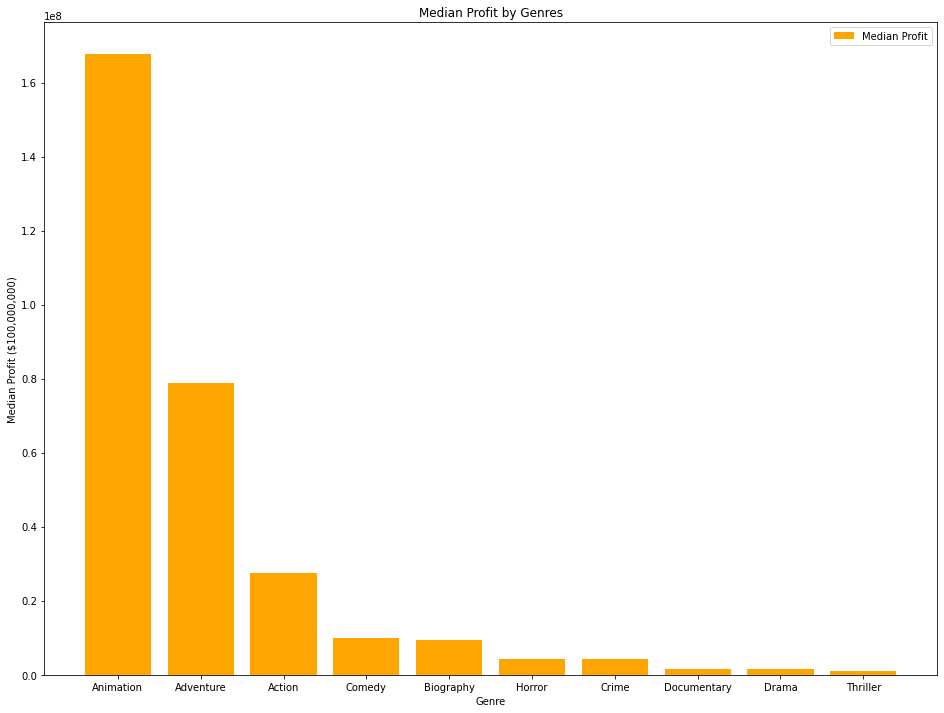

In [263]:
# Plotting median profit by genre
median_df = median_df.sort_values(by='Median Profit', ascending=False)

fig, ax = plt.subplots(figsize=(16,12))


ax.bar(median_df['Genres'], median_df['Median Profit'], color='orange', label='Median Profit')

ax.set_xlabel('Genre')
ax.set_ylabel('Median Profit ($100,000,000)')
ax.set_title('Median Profit by Genres')
ax.legend()

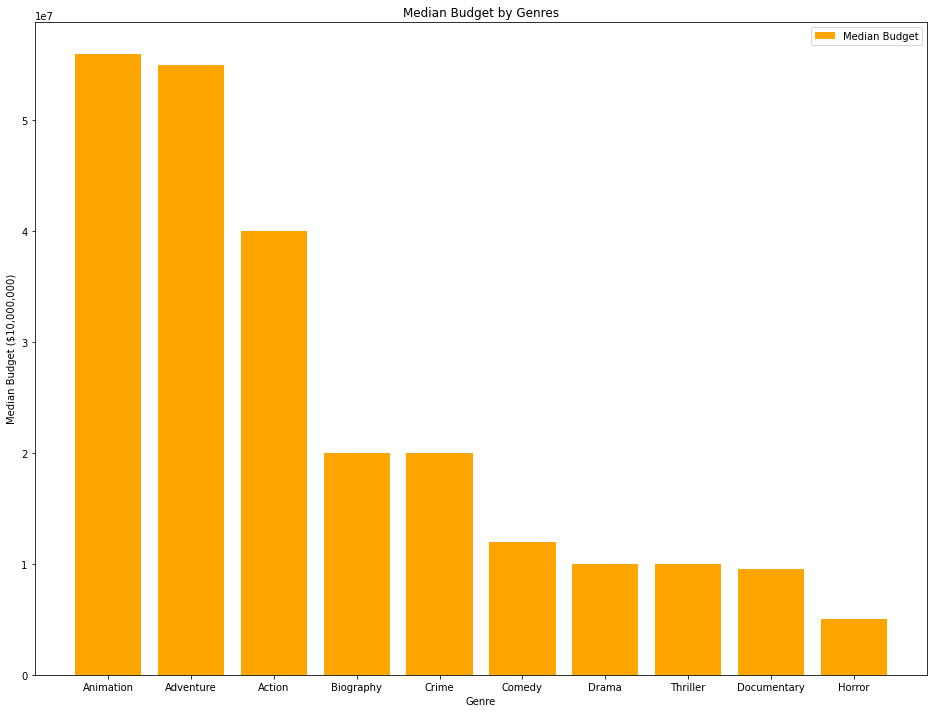

In [264]:
# Plotting median budget by genre
median_df = median_df.sort_values(by='Median Budget', ascending=False)

fig, ax = plt.subplots(figsize=(16,12))


ax.bar(median_df['Genres'], median_df['Median Budget'], color='orange', label='Median Budget')

ax.set_xlabel('Genre')
ax.set_ylabel('Median Budget ($10,000,000)')
ax.set_title('Median Budget by Genres')
ax.legend()

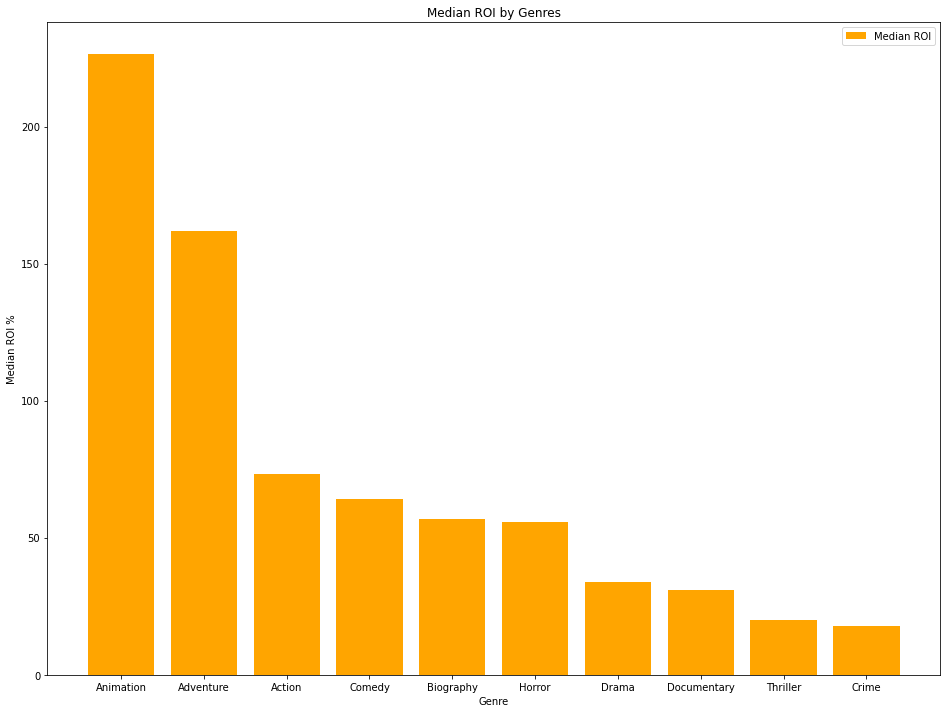

In [265]:
# Plotting median roi by genre
median_df = median_df.sort_values(by='Median ROI', ascending=False)

fig, ax = plt.subplots(figsize=(16,12))


ax.bar(median_df['Genres'], median_df['Median ROI'], color='orange', label='Median ROI')

ax.set_xlabel('Genre')
ax.set_ylabel('Median ROI %')
ax.set_title('Median ROI by Genres')
ax.legend()

In [266]:
# Getting the top 4 genres by roi
top_4_roi = median_df.iloc[0:4, :]

In [267]:
# Putting the top 4 genre names into a list
top_4_roi_index = list(top_4_roi['Genres'])

In [268]:
# Creating a new dataframe with only movies from the top 4 genres
top_4_genres = combined.loc[(combined['main_genre'] == 'Animation')|
                            (combined['main_genre'] == 'Adventure') |
                            (combined['main_genre'] == 'Action')    |
                            (combined['main_genre'] == 'Comedy')]

In [269]:
# Extracting the release month
top_4_genres['release_month'] = top_4_genres['release_date'].str[5:7].astype(int)

<ipython-input-269-136f0e6409f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_4_genres['release_month'] = top_4_genres['release_date'].str[5:7].astype(int)


In [270]:
# Grouping by the genre month
grouped_genre_month = top_4_genres.groupby('main_genre')

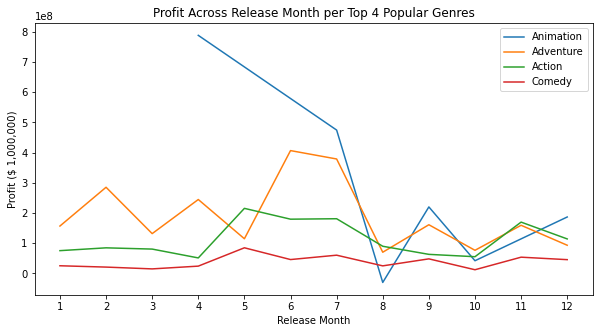

In [271]:
# Plotting profits by month for each of the top 4 genres
fig, ax = plt.subplots(figsize=(10,5))

for genre in top_4_roi_index:
        x_month = grouped_genre_month.get_group(genre)['release_month'].value_counts().sort_index().index
        y_month = grouped_genre_month.get_group(genre).groupby('release_month')['profit'].mean()
        ax.plot(x_month, y_month, label=f"{genre}")
ax.set_xticks(range(1,13))
ax.set_title('Profit Across Release Month per Top 4 Popular Genres')
ax.set_xlabel('Release Month')
ax.set_ylabel('Profit ($ 1,000,000)')
ax.legend()

## Simple Linear Regression Model

In [272]:
# Creating a copy of the combined dataframe for linear regression model
tmdb_movie = combined.copy()

In [273]:
# First, creating a dictionary with genres and counts
top_10_genres_index = list(tmdb_movie['main_genre'].value_counts()[:10].keys())
top_10_genre_counts = tmdb_movie['main_genre'].value_counts()[:10]
top_10_genres = dict(zip(top_10_genres_index, top_10_genre_counts))

In [274]:
# Changing values so that they are in millions for visualization
columns = ['production_budget', 'profit']

tmdb_movie[columns] = tmdb_movie[columns].apply(lambda x: x/1000000)

In [275]:
# Getting a separate dataframe with top ten genres
ten_genres_df = tmdb_movie.loc[tmdb_movie['main_genre'].isin(top_10_genres_index)]
ten_genres_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 1 to 2215
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   original_title      1610 non-null   object 
 1   genres              1610 non-null   object 
 2   averagerating       1610 non-null   float64
 3   numvotes            1610 non-null   int64  
 4   main_genre          1610 non-null   object 
 5   subgenre_1          1269 non-null   object 
 6   subgenre_2          872 non-null    object 
 7   primary_name        1610 non-null   object 
 8   primary_profession  1610 non-null   object 
 9   id                  1610 non-null   int64  
 10  movie               1610 non-null   object 
 11  production_budget   1610 non-null   float64
 12  domestic_gross      1610 non-null   float64
 13  worldwide_gross     1610 non-null   float64
 14  profit              1610 non-null   float64
 15  roi                 1610 non-null   float64
 16  releas

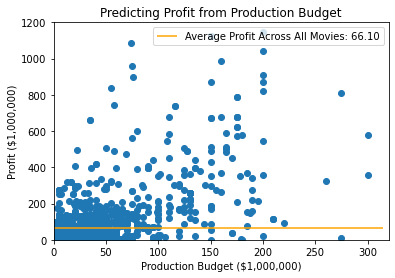

In [276]:
# Baseline model is the overall average profit across all movies 
X = ten_genres_df['production_budget'].values
y = ten_genres_df['profit'].values

plt.scatter(X, y)

xmin, xmax = plt.xlim()
plt.hlines(y=y.mean(),
            xmin=xmin, xmax=xmax,
            label=f"Average Profit Across All Movies: {y.mean():.2f}",
            colors='orange')
plt.xlim([0,320])
plt.ylim([0,1200])
plt.title('Predicting Profit from Production Budget')
plt.xlabel('Production Budget ($1,000,000)')
plt.ylabel('Profit ($1,000,000)')
plt.legend()

In [277]:
# Instantiating the linear regression object
lr = LinearRegression()

In [278]:
# Performing a fit on the model
lr.fit(ten_genres_df[['production_budget']], y)

LinearRegression()

In [279]:
# Getting our linear regression model
m = lr.coef_
b = lr.intercept_
lm_model = m*ten_genres_df['production_budget'].values + b

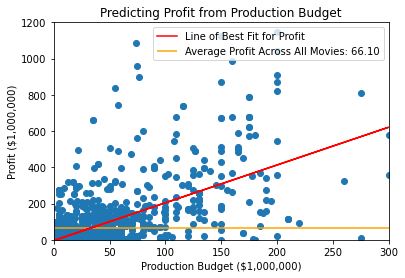

In [280]:
# Creating a scatter plot with the baseline model and the linear regression model
plt.scatter(X, y)
plt.plot(ten_genres_df['production_budget'].values, 
        lm_model, 
        label = 'Line of Best Fit for Profit',
        color='red')

xmin, xmax = plt.xlim()
plt.hlines(y=y.mean(),
            xmin=xmin, xmax=xmax,
            label=f"Average Profit Across All Movies: {y.mean():.2f}",
            colors='orange')

plt.xlim([0,300])
plt.ylim([0,1200])
plt.title('Predicting Profit from Production Budget')
plt.xlabel('Production Budget ($1,000,000)')
plt.ylabel('Profit ($1,000,000)')
plt.legend()
# same as this
# sns.lmplot(x='production_budget', y='worldwide_gross', data=tn_movie_budgets)

In [281]:
# Production budget prediction to result in average profit
pred_budget = (y.mean() - b)/m
pred_budget[0]

33.772493377639755

In [282]:
# Calculating R squared metric to evaluate the model
r2_score(y, lm_model)

0.37126099851755656

In [283]:
# Calculating mean squared metric to evaluate the model
mean_squared_error(y, lm_model)

14682.728775236057

In [284]:
# Comparing with our baseline model,
# Which is the overall average profit
base_model = 0*ten_genres_df['production_budget'].values + y.mean()
r2_score(y, base_model)

0.0

In [285]:
# Calculating mean squared metric to evaluate the base model
mean_squared_error(y, base_model)

23352.661025667338

## Main Findings and Conclusions

**The ROI for Animation is 226% - almost twice the industry standard of 120%.**

- Animation, Adventure, and Action generate the most profit per movie

- Animation, Adventure, and Action also have the highest budgets, but have the highest Return on Investment

- Comedy is 4th in the ROI metric, but with a significantly lower median budget 

- If our movie studio is creating a movie with a high budget, we propose Action, Adventure, and Animation movies, because of their overall high profit in return. 

- On the other hand, we recommend Comedy for a low budget movie, based on its high ROI value.

- As our movie studio is just getting started in the movie industry, we propose March to April release in order to avoid the competition from the big movie studios in the summer.


## Appendix

Below is additional analysis we performed that was not used our final analysis and visualizations

In [286]:
# Creating a new dataframe grouping the means of each column by genre
means = combined.groupby(['main_genre']).mean()

In [287]:
# Creating a list of the mean roi of each genre
means = means.sort_values(by='roi', ascending=False)
means = means.drop(index='Family')
genres = list(means.index)
mean_roi = []
for genre in genres:
    df = combined.loc[combined['main_genre'] == genre]
    mean_roi.append(df.roi.mean())

In [288]:
# Creating a profits dataframe which has sorted the means by profit
profits = means.sort_values(by='profit', ascending=False)

In [289]:
# Creating lists of the genres and the mean profits
profit_index = profits.index
mean_profit = list(profits['profit'])

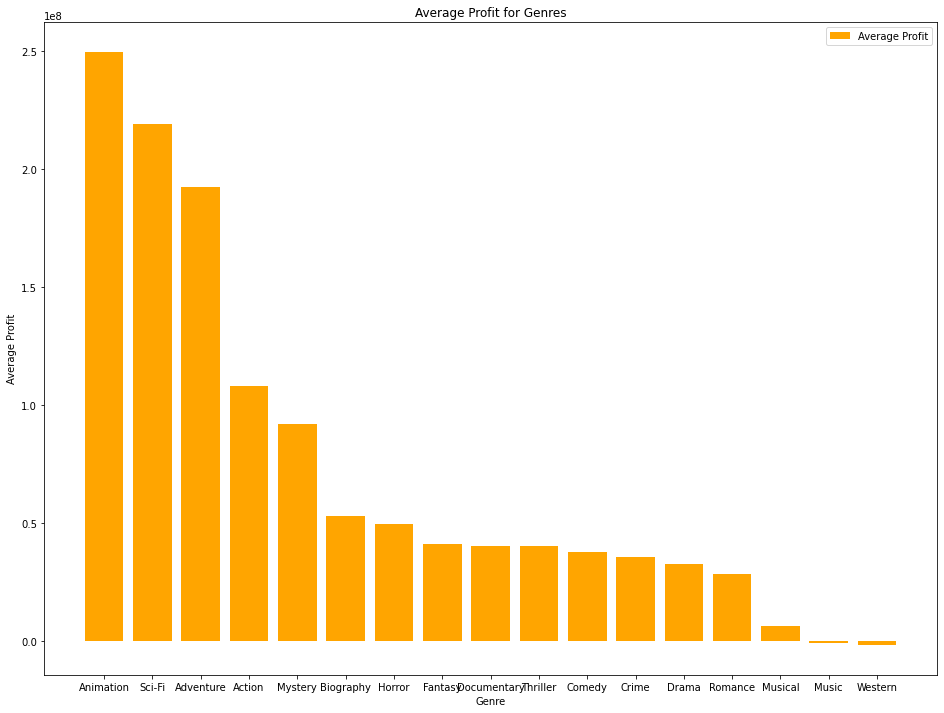

In [290]:
# Plotting the average profit by genre
fig, ax = plt.subplots(figsize=(16,12))

x = profits.index
y = profits['profit']

ax.bar(x, y, color='orange', label='Average Profit')

ax.set_xlabel('Genre')
ax.set_ylabel('Average Profit')
ax.set_title('Average Profit for Genres')
ax.legend()

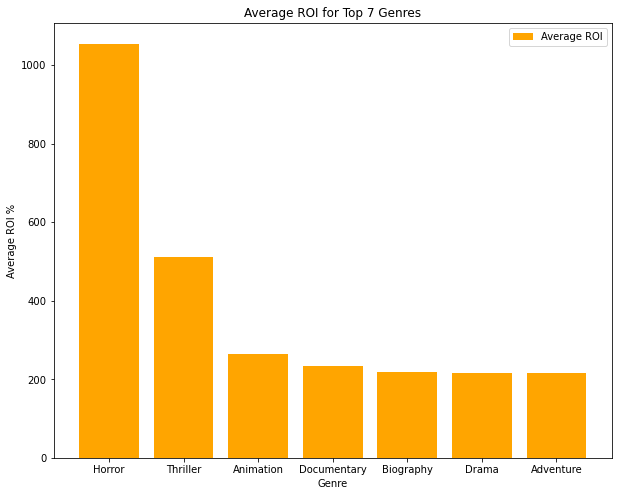

In [291]:
# Plotting the top 7 genres by average ROI
fig, ax = plt.subplots(figsize=(10,8))
x = means.index[0:7]
y = mean_roi[0:7]

ax.bar(x, y, color='orange', label='Average ROI')

ax.set_xlabel('Genre')
ax.set_ylabel('Average ROI %')
ax.set_title('Average ROI for Top 7 Genres')
ax.legend()

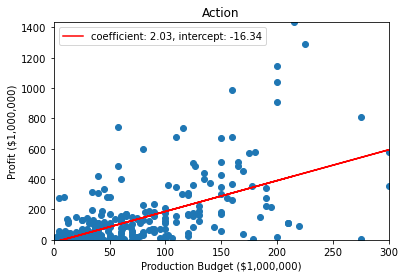

R squared for Action is 0.36138151598007806


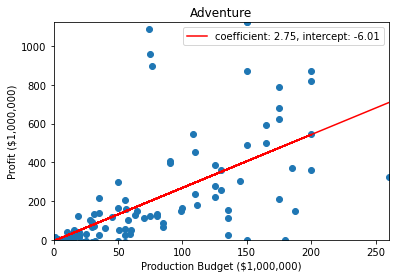

R squared for Adventure is 0.3775709368985045


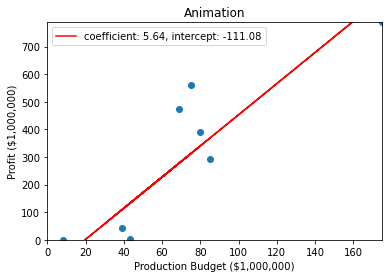

R squared for Animation is 0.7939588333098003


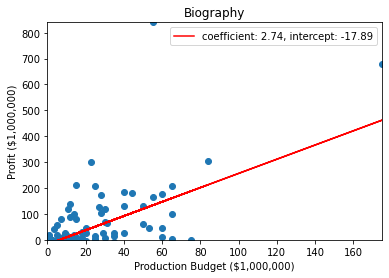

R squared for Biography is 0.2926792732971828


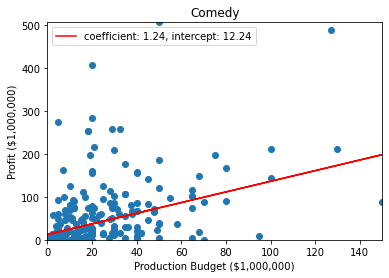

R squared for Comedy is 0.15531213325797755


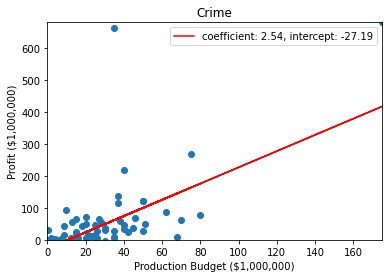

R squared for Crime is 0.3514105584193019


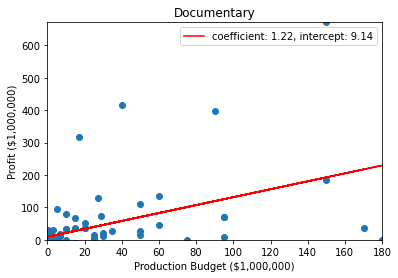

R squared for Documentary is 0.2113953167286775


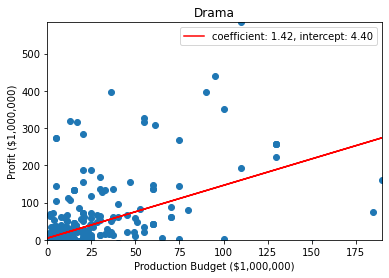

R squared for Drama is 0.248431523870715


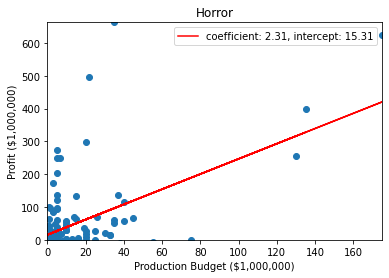

R squared for Horror is 0.2669584217876054


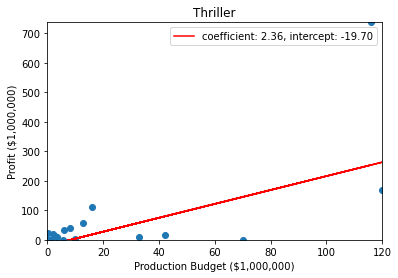

R squared for Thriller is 0.30805562096009576


""


In [292]:
# Group wise linear regression and plot them individually
# Focusing on top 7 genres only
grouped_tmdb_movie = ten_genres_df.groupby(['main_genre'])

def model(df):
    y = df[['profit']].values
    X = df[['production_budget']].values
    lr = LinearRegression()
    lr.fit(X, y)
    m = lr.coef_
    b = lr.intercept_
    y_model = m*X + b
    plt.scatter(X,y)
    plt.plot(X, y_model, color='red', label=f"coefficient: {m[0][0]:.2f}, intercept: {b[0]:.2f}")
    plt.title(f"{df['main_genre'].values[0]}")
    plt.xlim([0,X.max()])
    plt.ylim([0,y.max()])
    plt.xlabel("Production Budget ($1,000,000)")
    plt.ylabel("Profit ($1,000,000)")
    plt.legend()
    plt.show()
    print(f"R squared for {df['main_genre'].values[0]} is {r2_score(y, y_model)}")

grouped_tmdb_movie.apply(model)

In [293]:
# Performing ANOVA tests for genre and profit
genre_groups = {}
for genre in top_10_genres_index:
    genre_groups[genre] = ten_genres_df.loc[ten_genres_df['main_genre'] == genre]['profit'].values

result = stats.f_oneway(*genre_groups.values())
f_stat, p_value = result
result

F_onewayResult(statistic=19.038812104512726, pvalue=1.6574875740045487e-30)

In [294]:
# Printing out the comparison of the means by genre
tukey = pairwise_tukeyhsd(endog=ten_genres_df['profit'], groups=ten_genres_df['main_genre'], alpha=0.05)
print(tukey)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1      group2    meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------
     Action   Adventure    84.138    0.0   34.0102  134.2659   True
     Action   Animation   141.436 0.0751   -6.5447  289.4166  False
     Action   Biography  -55.2305 0.0269 -107.2193   -3.2417   True
     Action      Comedy  -70.4975    0.0 -106.1922  -34.8028   True
     Action       Crime   -72.551 0.0007 -125.8056  -19.2963   True
     Action Documentary  -67.7293 0.0068 -124.7955  -10.6631   True
     Action       Drama  -75.4394    0.0 -109.1992  -41.6795   True
     Action      Horror  -58.5581 0.0044 -106.4938  -10.6223   True
     Action    Thriller  -67.7602  0.396 -161.5024   25.9821  False
  Adventure   Animation   57.2979 0.9738  -95.0969  209.6927  False
  Adventure   Biography -139.3685    0.0 -202.8409  -75.8962   True
  Adventure      Comedy -154.6355    0.0 -205.62